In [0]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet,  HuberRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score ,RandomizedSearchCV
from sklearn import metrics

In [119]:
data = pd.read_csv('airbnb.csv')

print('Number of features: %s' %data.shape[1])
print('Number of examples: %s' %data.shape[0])

Number of features: 16
Number of examples: 48895


In [120]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [121]:
# Describing the columns with only numerical values

data.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review'], axis=1).describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [122]:
# Printing unique values for string columns

for col in data[['neighbourhood_group', 'neighbourhood', 'room_type']]:
    print('Unique values in column: %s' %col)
    print(data[col].unique()), '\n'

Unique values in column: neighbourhood_group
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Unique values in column: neighbourhood
['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason 

# Null values

In [123]:
print('Null values in Airbnb dataset: \n')
print(data.isnull().sum())
print('\n')
print('Percentage of null values in review columns: ')
print(round(data['last_review'].isnull().sum()/len(data)*100, 2),"%")
 
# Lets see if the null values is for the same rows.
# I want to see also how null values for name and host_name are distributed because these amounts are different

Null values in Airbnb dataset: 

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


Percentage of null values in review columns: 
20.56 %


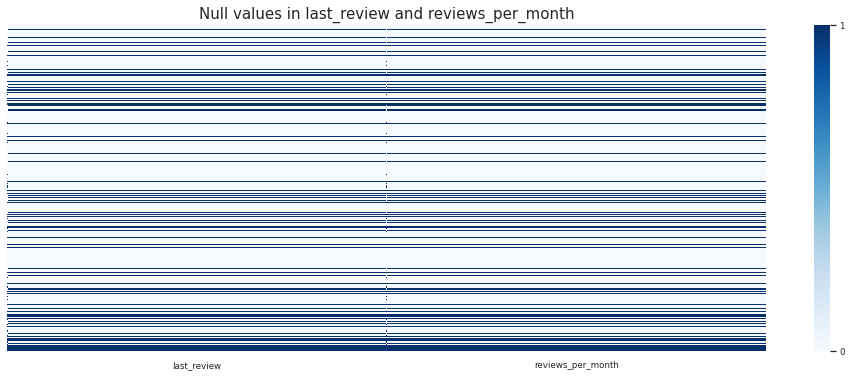

In [124]:
fig, ax = plt.subplots(figsize=(17,6))
plt.title('Null values in last_review and reviews_per_month', fontsize=15)
sns.heatmap(data[['last_review','reviews_per_month' ]].isnull(), cmap="Blues", yticklabels=False,ax=ax,cbar_kws={'ticks': [0, 1]})

In [0]:
# last_review column may be dropped

data.drop('last_review', axis=1, inplace=True)

In [0]:
# Null values for name and host_name I replace with 0. Also reviews_per_month I replace with 0

data['name'].fillna(value=0, inplace=True)

In [0]:
data['host_name'].fillna(value=0, inplace=True)

In [0]:
data['reviews_per_month'].fillna(value=0, inplace=True)

In [129]:
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [130]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


# **Evaluations**

### 1.Top 3 hosts

In [131]:
data.host_id.value_counts()

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
            ... 
1641589        1
4070519        1
208106618      1
235939247      1
1288080        1
Name: host_id, Length: 37457, dtype: int64

In [132]:
top_3_hosts = (pd.DataFrame(data.host_id.value_counts())).head(3)
top_3_hosts

,host_id
219517861,327
107434423,232
30283594,121


In [133]:
top_3_hosts.columns=['Listings']
top_3_hosts

,Listings
219517861,327
107434423,232
30283594,121


In [134]:
top_3_hosts['host_id'] = top_3_hosts.index
top_3_hosts

,Listings,host_id
219517861,327,219517861
107434423,232,107434423
30283594,121,30283594


In [135]:
top_3_hosts.reset_index(drop=True, inplace=True)
top_3_hosts

,Listings,host_id
0,327,219517861
1,232,107434423
2,121,30283594


### 2.Top 3 neighbourhoods

In [136]:
top_3_neigh = pd.DataFrame(data['neighbourhood_group'].value_counts().head(3))
top_3_neigh

,neighbourhood_group
Manhattan,21661
Brooklyn,20104
Queens,5666


In [0]:
top_3_neigh.columns=['Listings']
top_3_neigh['Neighbourhood Group'] = top_3_neigh.index

In [138]:
top_3_neigh

,Listings,Neighbourhood Group
Manhattan,21661,Manhattan
Brooklyn,20104,Brooklyn
Queens,5666,Queens


In [139]:
top_3_neigh.reset_index(drop=True, inplace=True)
top_3_neigh

,Listings,Neighbourhood Group
0,21661,Manhattan
1,20104,Brooklyn
2,5666,Queens


## 3.Average price and availability

In [140]:
average_price_ava = pd.DataFrame(data[['price', 'availability_365']].describe())
average_price_ava

,price,availability_365
count,48895.000000,48895.000000
mean,152.720687,112.781327
std,240.154170,131.622289
min,0.000000,0.000000
25%,69.000000,0.000000
50%,106.000000,45.000000
75%,175.000000,227.000000
max,10000.000000,365.000000


In [141]:
average_price_ava.columns=['Price', 'Availability in a year']
average_price_ava

,Price,Availability in a year
count,48895.000000,48895.000000
mean,152.720687,112.781327
std,240.154170,131.622289
min,0.000000,0.000000
25%,69.000000,0.000000
50%,106.000000,45.000000
75%,175.000000,227.000000
max,10000.000000,365.000000


## 4.Hosts who are most reviewed

In [142]:
rev_group = pd.DataFrame(data.groupby('number_of_reviews').sum()['host_id'])
rev_group

,host_id
number_of_reviews,
0,811039310308
1,371988214237
2,236887012162
3,177893012449
4,144577461627
...,...
576,47621202
594,4734398
597,4734398


In [144]:
most_reviewed = (rev_group.sort_values('number_of_reviews',ascending=False)).head(3)
most_reviewed

,host_id
number_of_reviews,
629,47621202
607,4734398
597,4734398


In [145]:
most_reviewed.columns = ['Host ID']
most_reviewed['Number of reviews'] = most_reviewed.index
most_reviewed.reset_index(drop=True, inplace=True)
most_reviewed

,Host ID,Number of reviews
0,47621202,629
1,4734398,607
2,4734398,597


## 5.Hosts who are most reviewed per month

In [146]:
gr = pd.DataFrame(data.groupby('reviews_per_month').sum()['host_id'])
gr

,host_id
reviews_per_month,
0.00,811039310308
0.01,162335997
0.02,19323462025
0.03,23450102638
0.04,19063643696
...,...
17.82,156684502
19.75,156684502
20.94,228415932


In [147]:
rev = (gr.sort_values('reviews_per_month',ascending=False)).head(3)
rev

,host_id
reviews_per_month,
58.50,244361589
27.95,244361589
20.94,228415932


In [148]:
rev.columns = ['Host ID']
rev['Reviews per month'] = rev.index
rev.reset_index(drop=True, inplace=True)
rev

,Host ID,Reviews per month
0,244361589,58.50
1,244361589,27.95
2,228415932,20.94


## Prices in different neighbourhood group

In [149]:
# Brooklyn
nei1 = data.loc[data['neighbourhood_group'] == 'Brooklyn']
nei1

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,1,0
12,5803,"Lovely Room 1, Garden, Best Area, Legal rental",9744,Laurie,Brooklyn,South Slope,40.66829,-73.98779,Private room,89,4,167,1.34,3,314
15,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,140,2,148,1.20,1,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48882,36482231,Bushwick _ Myrtle-Wyckoff,66058896,Luisa,Brooklyn,Bushwick,40.69652,-73.91079,Private room,40,20,0,0.00,1,31
48884,36482783,Brooklyn Oasis in the heart of Williamsburg,274307600,Jonathan,Brooklyn,Williamsburg,40.71790,-73.96238,Private room,190,7,0,0.00,1,341
48887,36483152,Garden Jewel Apartment in Williamsburg New York,208514239,Melki,Brooklyn,Williamsburg,40.71232,-73.94220,Entire home/apt,170,1,0,0.00,3,365
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0.00,2,9


In [0]:
price_nei1 = nei1[['price']]

In [151]:
price_nei1

,price
0,149
3,89
6,60
12,89
15,140
...,...
48882,40
48884,190
48887,170
48890,70


In [152]:
# Manhattan
nei2 = data.loc[data['neighbourhood_group'] == 'Manhattan']
price_nei2 = nei2[['price']]
price_nei2

,price
1,225
2,150
4,80
5,200
7,79
...,...
48886,200
48888,125
48892,115
48893,55


In [153]:
# Queens
nei3 = data.loc[data['neighbourhood_group'] == 'Queens']
price_nei3 = nei3[['price']]
price_nei3

,price
46,130
77,70
143,140
161,79
181,350
...,...
48858,68
48863,93
48866,58
48878,45


In [154]:
# Staten Island
nei4 = data.loc[data['neighbourhood_group'] == 'Staten Island']
price_nei4 = nei4[['price']]
price_nei4

,price
169,70
249,36
250,37
251,37
256,36
...,...
48441,40
48446,100
48533,450
48649,54


In [155]:
# Bronx
nei5 = data.loc[data['neighbourhood_group'] == 'Bronx']
price_nei5 = nei5[['price']]
price_nei5

,price
171,40
207,45
260,90
261,105
309,90
...,...
48783,140
48792,80
48795,125
48796,70


In [156]:
price_nei5.describe().reset_index()

,index,price
0,count,1091.000000
1,mean,87.496792
2,std,106.709349
3,min,0.000000
4,25%,45.000000
5,50%,65.000000
6,75%,99.000000
7,max,2500.000000


In [157]:
price_list = [price_nei1, price_nei2, price_nei3, price_nei4, price_nei5]

price_stats = []
nei_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

# price statistics for every neighbourhood

for x in price_list:
    i = x.describe(percentiles=[.25, .5, .75])
    i = i.iloc[1:]
    i.reset_index(inplace=True)
    i.rename(columns={'index': 'Stats'}, inplace=True)
    price_stats.append(i)

price_stats[0].rename(columns={'price': nei_list[0]}, inplace=True)
price_stats[1].rename(columns={'price': nei_list[1]}, inplace=True)
price_stats[2].rename(columns={'price': nei_list[2]}, inplace=True)
price_stats[3].rename(columns={'price': nei_list[3]}, inplace=True)
price_stats[4].rename(columns={'price': nei_list[4]}, inplace=True)

# final view of dataframe

stats_df = price_stats
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df=stats_df[0].join(stats_df[1:])
stats_df

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Stats,,,,,
mean,124.383207,196.875814,99.517649,114.812332,87.496792
std,186.873538,291.383183,167.102155,277.620403,106.709349
min,0.000000,0.000000,10.000000,13.000000,0.000000
25%,60.000000,95.000000,50.000000,50.000000,45.000000
50%,90.000000,150.000000,75.000000,75.000000,65.000000
75%,150.000000,220.000000,110.000000,110.000000,99.000000
max,10000.000000,10000.000000,10000.000000,5000.000000,2500.000000


# Visualisations

## Count plot for neighbourhood groops with hue as room type

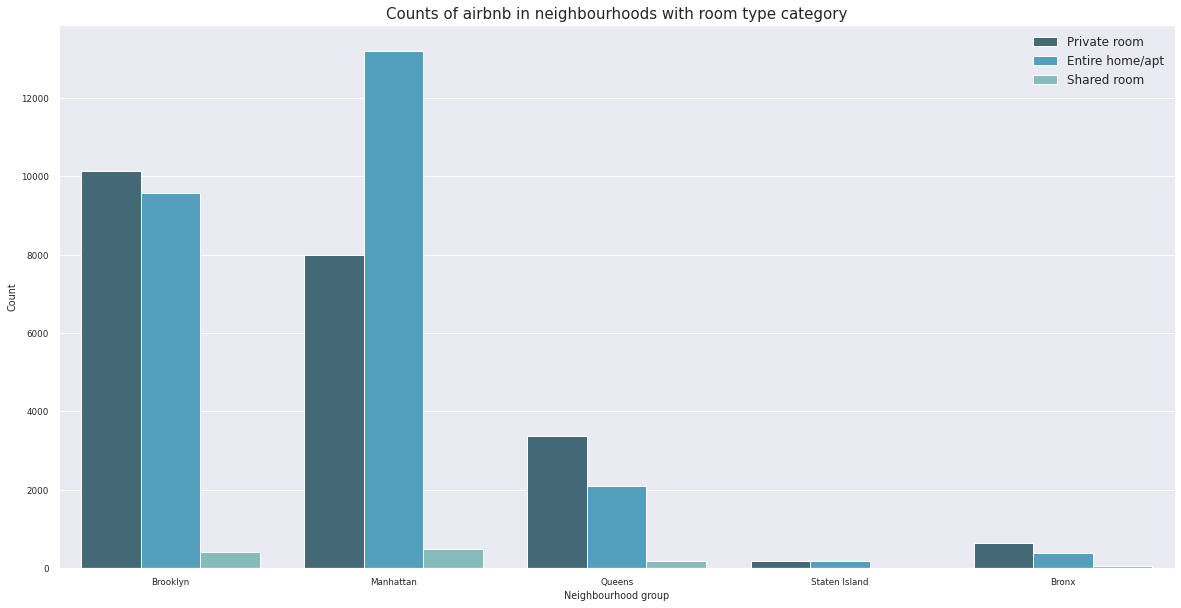

In [158]:
plt.figure(figsize=(20,10))
sns.countplot(data=data, x='neighbourhood_group', hue='room_type', palette='GnBu_d')
plt.title('Counts of airbnb in neighbourhoods with room type category', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Count")
plt.legend(frameon=False, fontsize=12)

## Distribution of prices with respect to neighbourhood group using violin plot

Text(0, 0.5, 'Price')

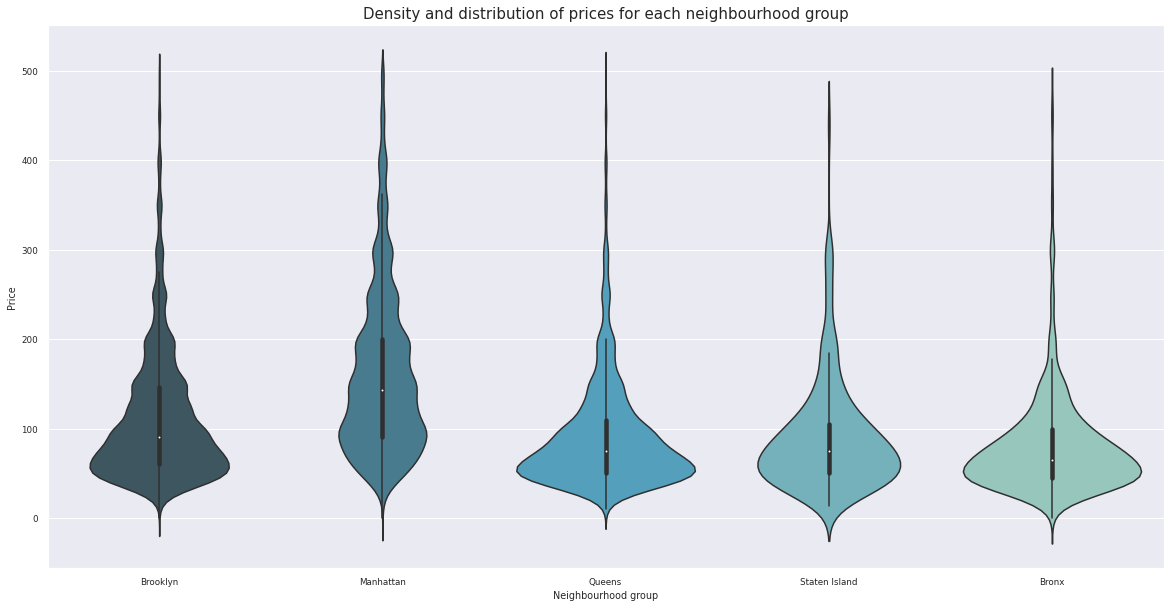

In [159]:
plt.figure(figsize=(20,10))
sns.violinplot(data=data[data.price <500], x='neighbourhood_group', y='price', palette='GnBu_d')
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")

## Top neighbourhoods according to room type

In [160]:
top_nei=data['neighbourhood'].value_counts().reset_index().head(10)
top_nei

,index,neighbourhood
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Harlem,2658
3,Bushwick,2465
4,Upper West Side,1971
5,Hell's Kitchen,1958
6,East Village,1853
7,Upper East Side,1798
8,Crown Heights,1564
9,Midtown,1545


In [0]:
top_nei = top_nei['index'].tolist()

In [162]:
top_nei

['Williamsburg',
 'Bedford-Stuyvesant',
 'Harlem',
 'Bushwick',
 'Upper West Side',
 "Hell's Kitchen",
 'East Village',
 'Upper East Side',
 'Crown Heights',
 'Midtown']

<Figure size 1440x720 with 0 Axes>

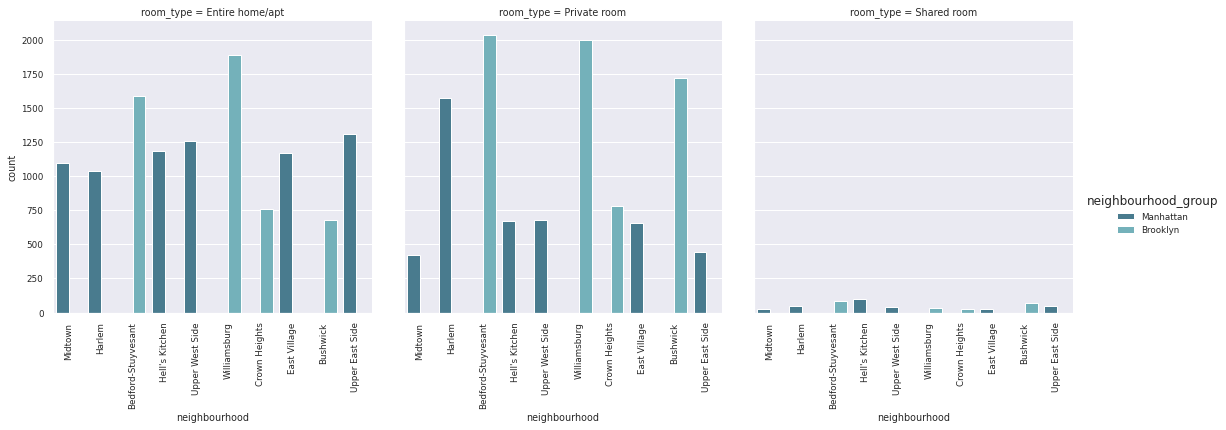

In [163]:
plt.figure(figsize=(20,10))
vis_3 = sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=data.loc[data['neighbourhood'].isin(top_nei)], kind='count', palette='GnBu_d')
vis_3.set_xticklabels(rotation=90)

## Count plot for room types

Text(0, 0.5, 'Count')

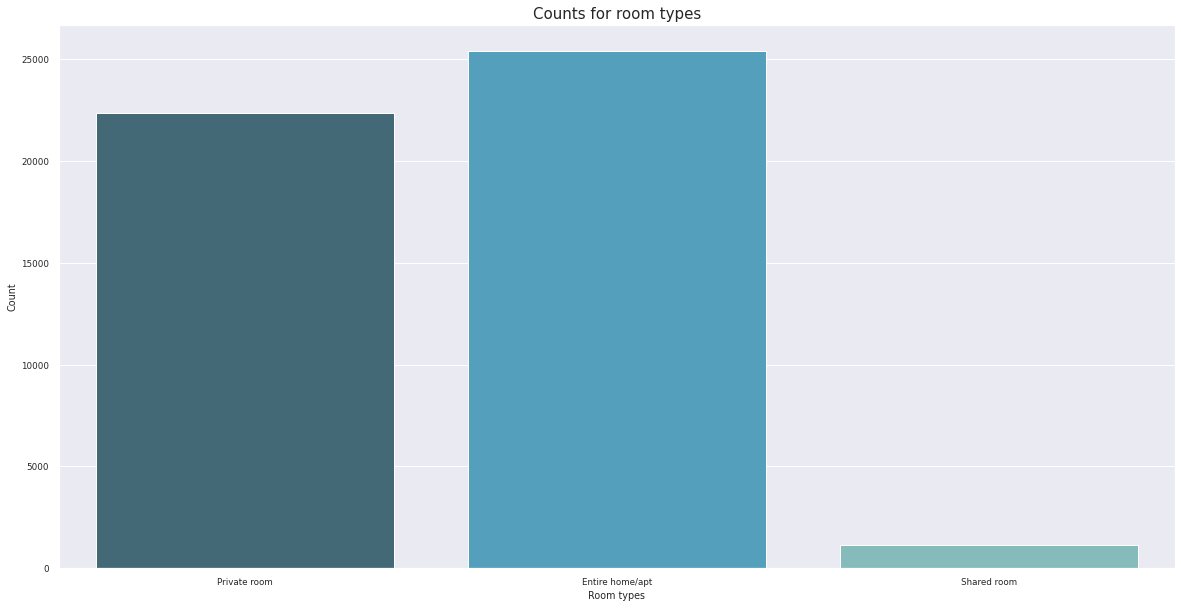

In [164]:
plt.figure(figsize=(20,10))
sns.countplot(data=data, x='room_type', palette='GnBu_d')
plt.title('Counts for room types', fontsize=15)
plt.xlabel('Room types')
plt.ylabel("Count")

## Avilability yearly

Text(0, 0.5, 'Frequency')

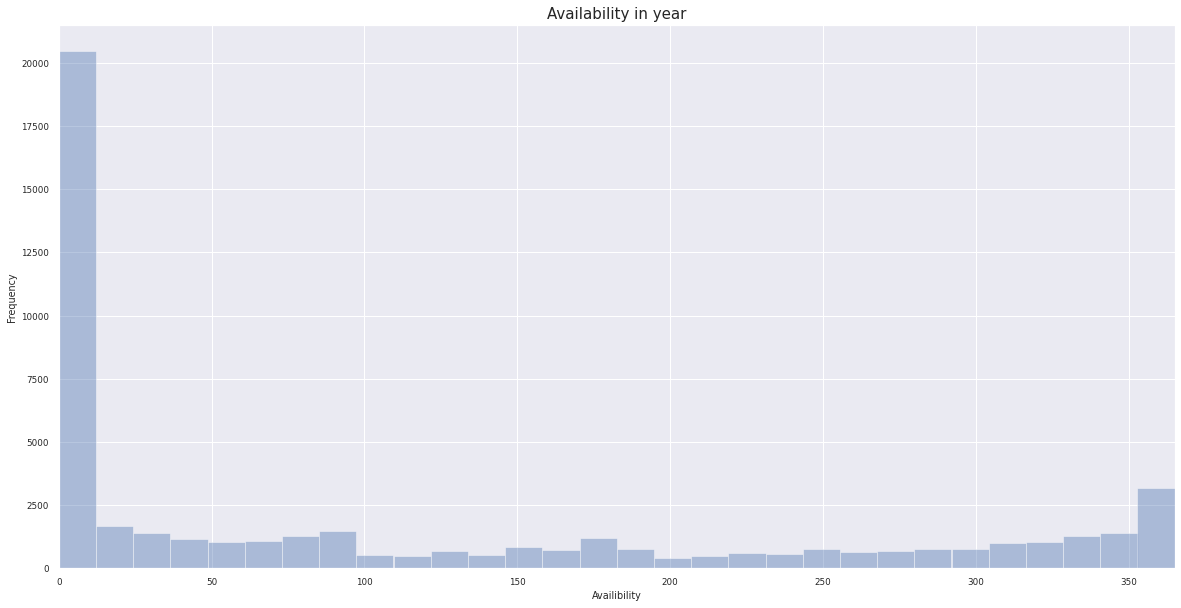

In [165]:
plt.figure(figsize=(20,10))
sns.distplot(data.availability_365, kde=False)
plt.xlim(0,365)
plt.title('Availability in year', fontsize=15)
plt.xlabel('Availibility')
plt.ylabel("Frequency")

## Map of the hosts

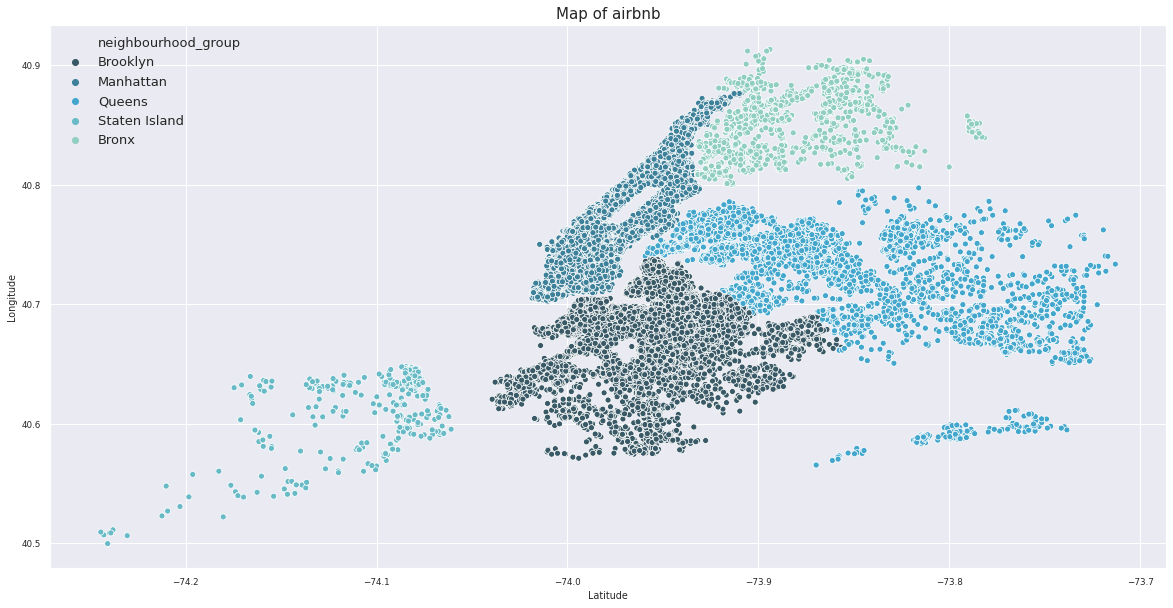

In [166]:
plt.figure(figsize=(20,10))
a = sns.scatterplot(data=data, x='longitude', y='latitude', hue='neighbourhood_group', palette='GnBu_d')
plt.title('Map of airbnb', fontsize=15)
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.legend(frameon=False, fontsize=13)

## Min Stay of nights

Text(0, 0.5, 'count')

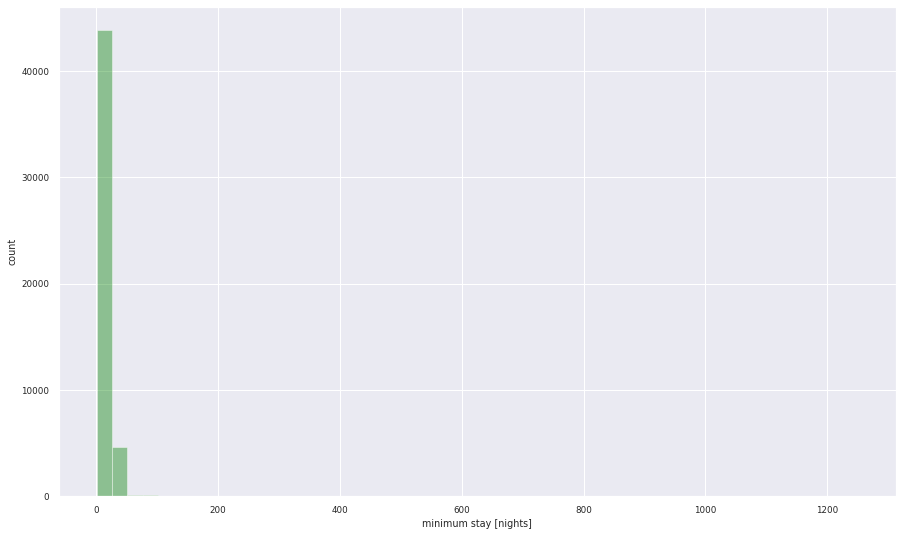

In [167]:
plt.figure(figsize=(15,9))
sns.distplot(data['minimum_nights'], rug=False, kde=False, color="green")
plt.xlabel("minimum stay [nights]")
plt.ylabel("count")

The distribution is very skewed.... and thats why i do this..!!

Text(0, 0.5, 'count')

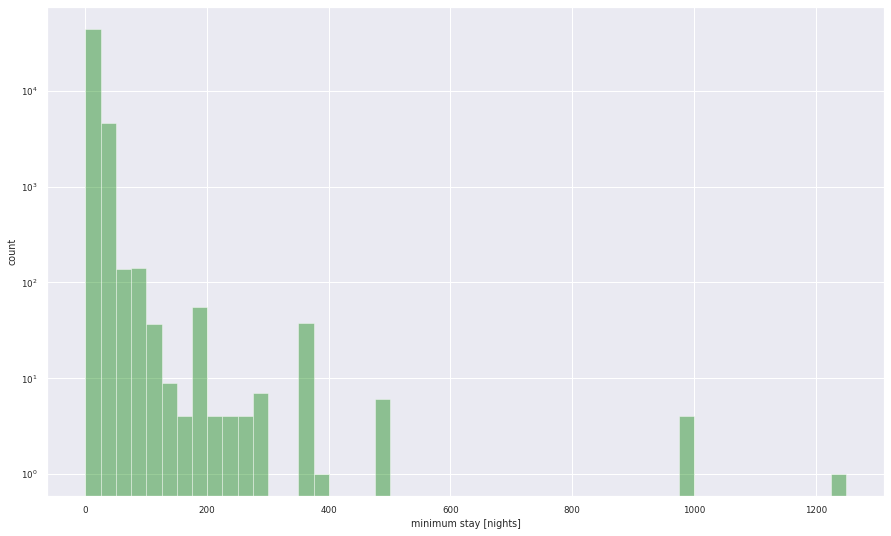

In [168]:
plt.figure(figsize=(15,9))
sns.distplot(data['minimum_nights'], rug=False, kde=False, color="green")
plt.yscale("log")
plt.xlabel("minimum stay [nights]")
plt.ylabel("count")

Quite better....!!!\
But lets project it in a more nice way..

Text(0, 0.5, 'count')

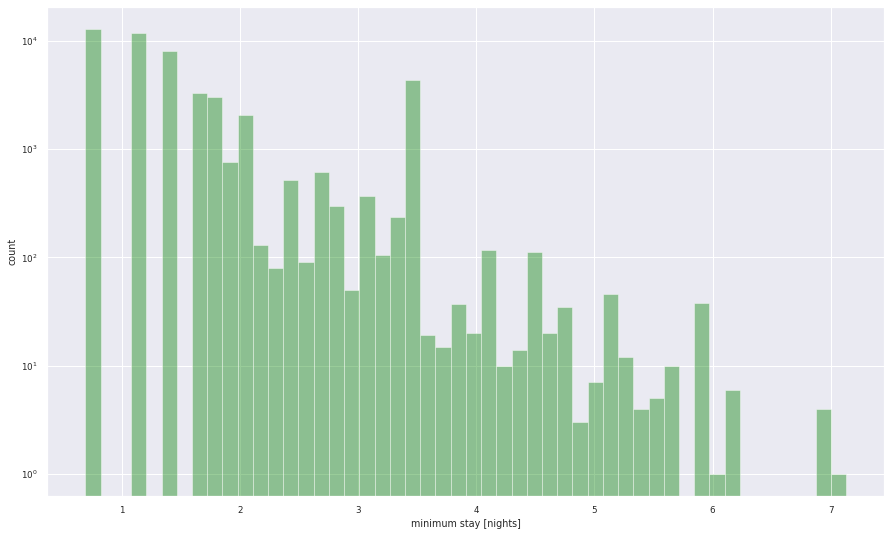

In [169]:
plt.figure(figsize=(15,9))
sns.distplot(np.log1p(data['minimum_nights']), rug=False, kde=False, color="green")
plt.yscale("log")
plt.xlabel("minimum stay [nights]")
plt.ylabel("count")

Now it makes Sense...!!

## Reviews per month.

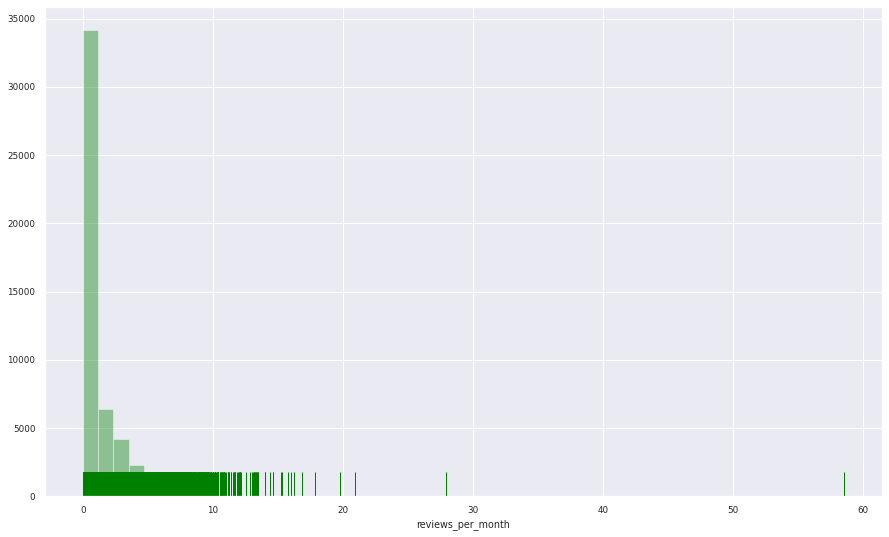

In [170]:
plt.figure(figsize=(15,9))
sns.distplot(data['reviews_per_month'], rug=True, kde=False, color="green")

Ok...\
So lets try and see it without the outliers..

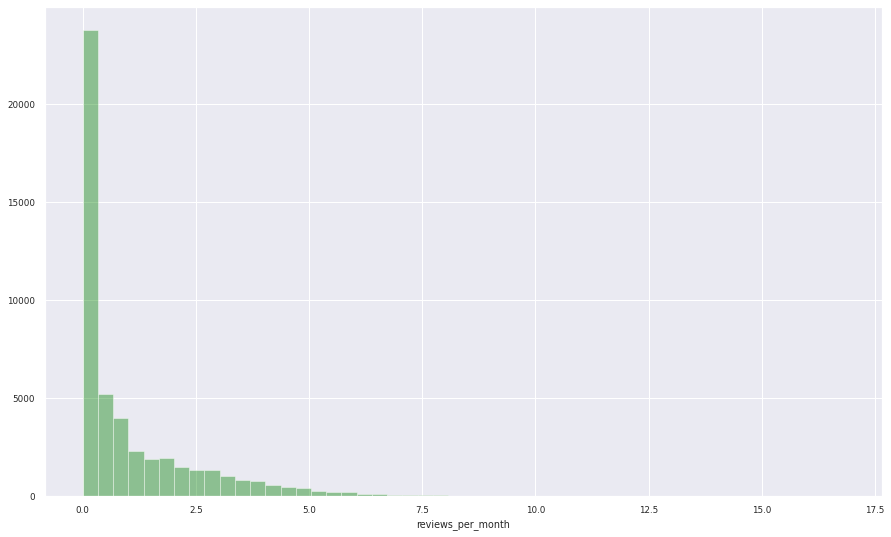

In [171]:
plt.figure(figsize=(15,9))
sns.distplot(data[data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=False, kde=False, color="green")

Again lets try and visualize the data nicely.... this time applying square root to it..

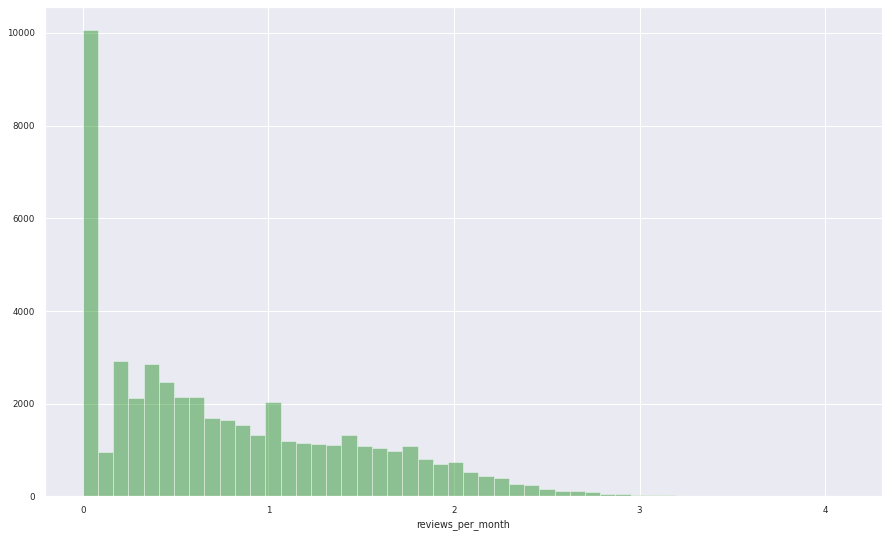

In [172]:
plt.figure(figsize=(15,9))
sns.distplot(np.sqrt(data[data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=False, kde=False, color="green")

Lets do it togethor...

Text(0.5, 0, 'ln(reviews_per_month)')

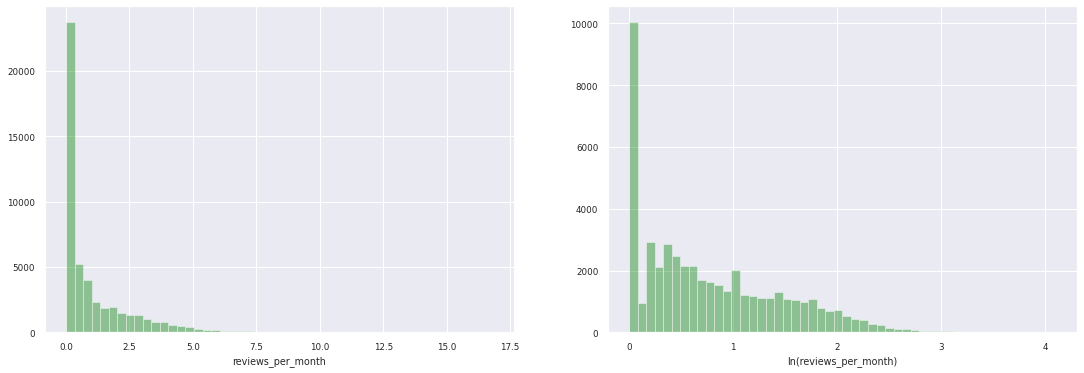

In [173]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(data[data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=False, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(data[data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=False, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

## The distribution of the number of reviews per month is highly skewed however way we cut it.

 However, a scatter plot of reviews_per_month and availability_365 variables shows no evidence of a relationship so that explanation would appear to not be valid.

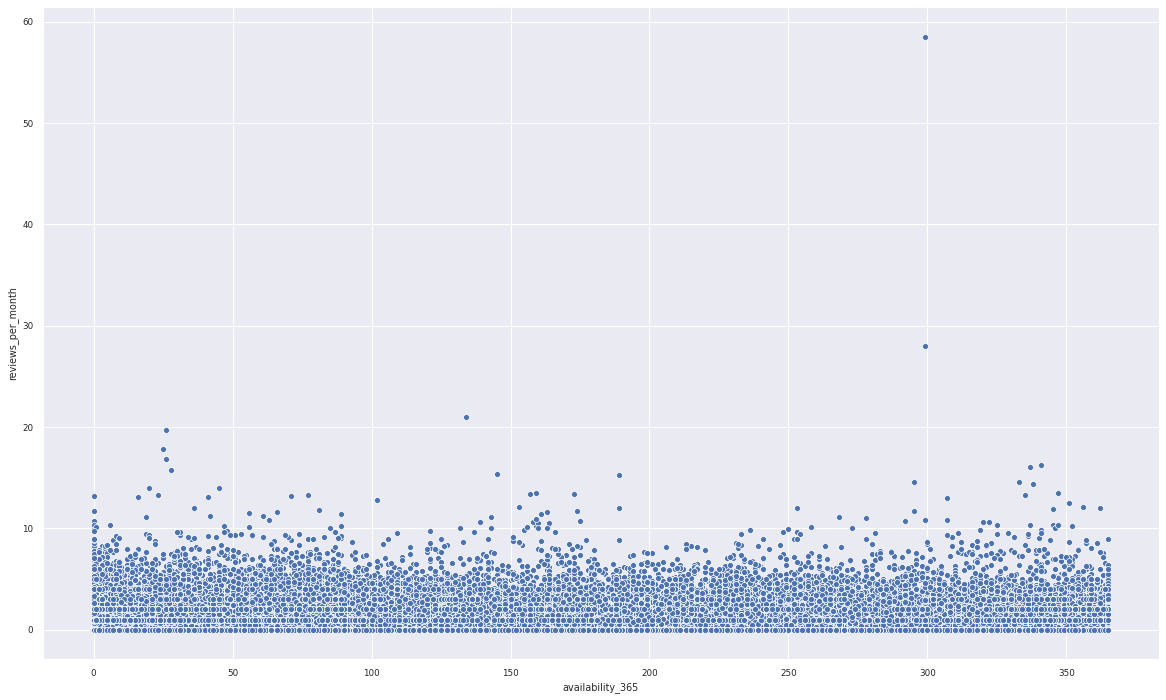

In [174]:
plt.figure(figsize=(20,12))
sns.scatterplot(x= data['availability_365'], y=data['reviews_per_month'])

## Lets see the prices in different neighbourhoods

In [175]:
data1 = pd.DataFrame(data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean())
data1.reset_index(inplace=True)
data1

,neighbourhood_group,neighbourhood,price
0,Bronx,Allerton,87.595238
1,Bronx,Baychester,75.428571
2,Bronx,Belmont,77.125000
3,Bronx,Bronxdale,57.105263
4,Bronx,Castle Hill,63.000000
...,...,...,...
216,Staten Island,Tottenville,144.857143
217,Staten Island,West Brighton,80.555556
218,Staten Island,Westerleigh,71.500000
219,Staten Island,Willowbrook,249.000000


In [0]:
bronx = (data1[data1['neighbourhood_group'] =='Bronx']).sort_values(by='price',ascending=False).head(10)
brooklyn = (data1[data1['neighbourhood_group'] =='Brooklyn']).sort_values(by='price',ascending=False).head(10)
manhattan = (data1[data1['neighbourhood_group'] =='Manhattan']).sort_values(by='price',ascending=False).head(10)
queens = (data1[data1['neighbourhood_group'] =='Queens']).sort_values(by='price',ascending=False).head(10)
staten = (data1[data1['neighbourhood_group'] =='Staten Island']).sort_values(by='price',ascending=False).head(10)

neighs = [bronx, brooklyn, manhattan, queens, staten]
titles = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

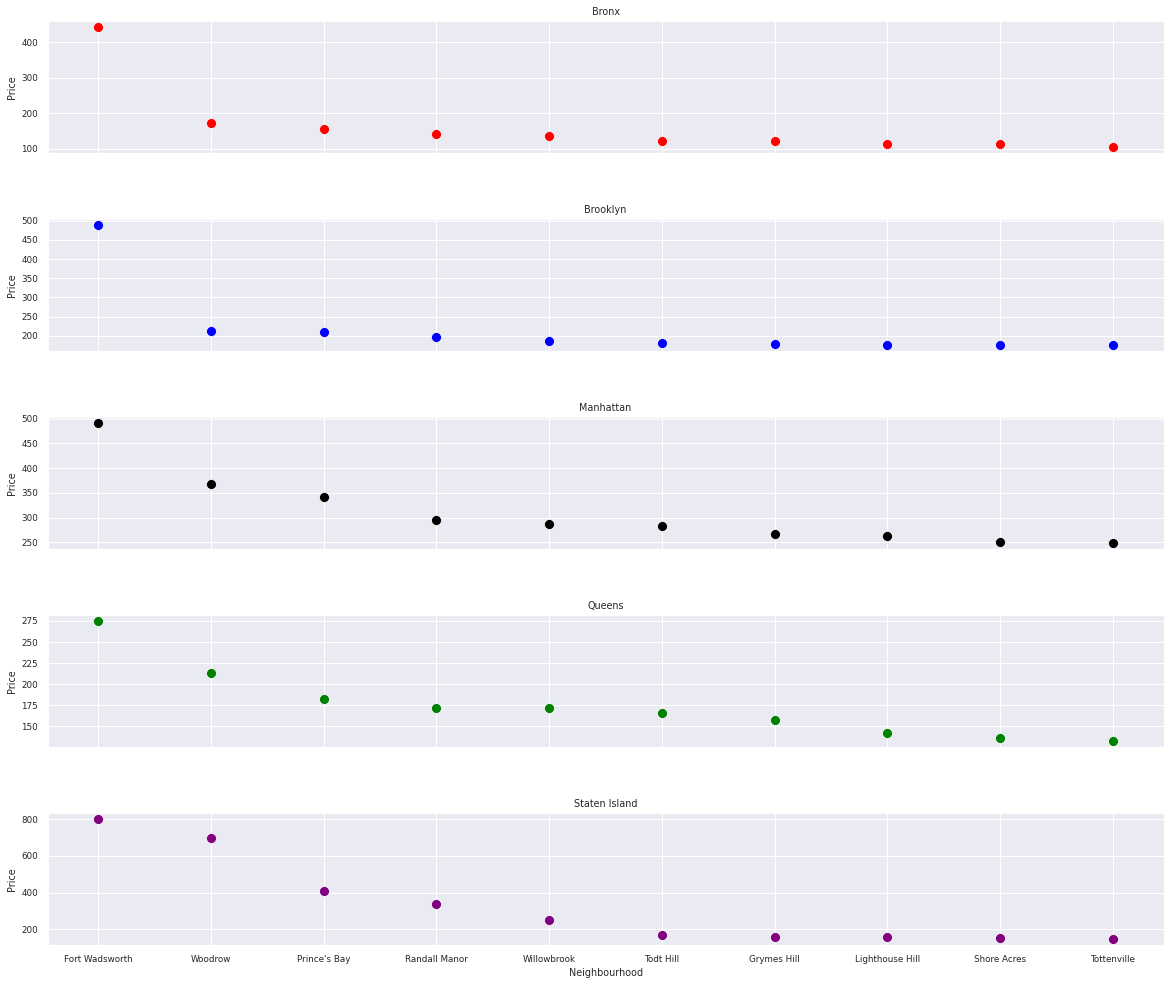

In [177]:
fig, axs = plt.subplots(5, figsize=(20, 17), gridspec_kw={'hspace': 0.5, 'wspace': 0})
sns.scatterplot(data=bronx, x='neighbourhood', y='price',ax=axs[0], color='red', s=100)
sns.scatterplot(data=brooklyn, x='neighbourhood', y='price', ax=axs[1], color='blue', s=100)
sns.scatterplot(data=manhattan, x='neighbourhood', y='price', ax=axs[2], color='black', s=100)
sns.scatterplot(data=queens, x='neighbourhood', y='price', ax=axs[3], color='green', s=100)
sns.scatterplot(data=staten, x='neighbourhood', y='price', ax=axs[4], color='purple', s=100)

axs[0].set_title('Bronx')
axs[1].set_title('Brooklyn')
axs[2].set_title('Manhattan')
axs[3].set_title('Queens')
axs[4].set_title('Staten Island')

for ax in axs:
    ax.set(xlabel='Neighbourhood', ylabel='Price')
    ax.label_outer()

# Predictions

In [0]:
# Preparing dataset for predictions

data_pred = pd.read_csv('airbnb.csv')

In [179]:
data_pred.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [0]:
data_pred['last_review'] = pd.to_datetime(data_pred['last_review'],infer_datetime_format=True) 

In [0]:
data_pred.drop(['name', 'host_name'], inplace=True, axis=1)

In [182]:
data_pred[data_pred['number_of_reviews']== 0.0].shape

(10052, 14)

Threfore all the null values in last reviews and reviews per month is due to the number of reviews

In [0]:
data_pred['reviews_per_month'] = data_pred['reviews_per_month'].fillna(0)

In [0]:
earliest = min(data_pred['last_review'])
data_pred['last_review'] = data_pred['last_review'].fillna(earliest)


In [185]:
earliest

Timestamp('2011-03-28 00:00:00')

In [186]:
data_pred.last_review

0       2018-10-19
1       2019-05-21
2       2011-03-28
3       2019-07-05
4       2018-11-19
           ...    
48890   2011-03-28
48891   2011-03-28
48892   2011-03-28
48893   2011-03-28
48894   2011-03-28
Name: last_review, Length: 48895, dtype: datetime64[ns]

Here i would call it as magic...

In [187]:
data_pred['last_review'] = data_pred['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())
data_pred.last_review

0        2762
1        2976
2           0
3        3021
4        2793
         ... 
48890       0
48891       0
48892       0
48893       0
48894       0
Name: last_review, Length: 48895, dtype: int64

well here i tried to convert the dates into the count of the days from the "earliest" date...

In [190]:
data_pred.isnull().sum()

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [191]:
data_pred.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2762,0.21,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2976,0.38,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,3021,4.64,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2793,0.10,1,0


# Price distribution (Dependent Variable Distribution)

 The target has a highly skewed distributions. This is problematic for machine learning algorithms such as linear regression.

Now lets try out some methods to solve this.. like log transformation or may be removal of outliers.

Text(0.5, 0, 'log(1+price)')

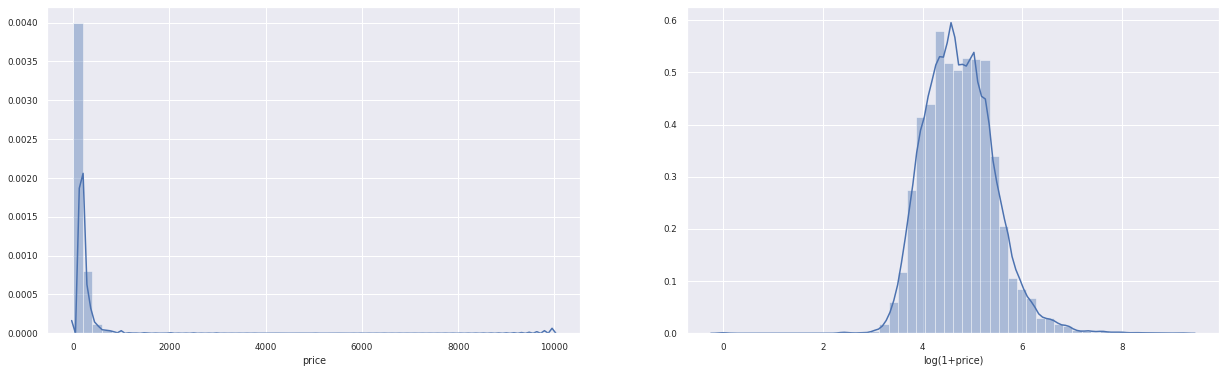

In [192]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(data_pred['price'], ax=axes[0])
sns.distplot(np.log1p(data_pred['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

In [193]:
data_pred = data_pred[np.log1p(data_pred['price']) < 8]
data_pred


,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2762,0.21,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2976,0.38,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,3021,4.64,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2793,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0,0.00,2,9
48891,36485057,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0,0.00,2,36
48892,36485431,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0,0.00,1,27
48893,36485609,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0,0.00,6,2


In [194]:
data_pred = data_pred[np.log1p(data_pred['price']) > 3]
data_pred

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2762,0.21,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2976,0.38,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,3021,4.64,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2793,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0,0.00,2,9
48891,36485057,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0,0.00,2,36
48892,36485431,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0,0.00,1,27
48893,36485609,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0,0.00,6,2


In [195]:
data_pred['price'] = np.log1p(data_pred['price'])
data_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,1,9,2762,0.21,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,1,45,2976,0.38,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,3,0,0,0.00,1,365
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,1,270,3021,4.64,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,10,9,2793,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,4.262680,2,0,0,0.00,2,9
48891,36485057,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,3.713572,4,0,0,0.00,2,36
48892,36485431,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,4.753590,10,0,0,0.00,1,27
48893,36485609,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,4.025352,1,0,0,0.00,6,2


# Predictor distributions (Independent Variables Distribution)

## Predictors

In [196]:
data_pred.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [197]:
print("Unique Hosts: {}".format(len(data_pred.host_id.unique())))

Unique Hosts: 37384


In [0]:
data_pred = data_pred.drop(['host_id', 'id'], axis=1)

## Reviews per Month

Since we found some outliers in the dataset for reviews per month..we need to remove it..

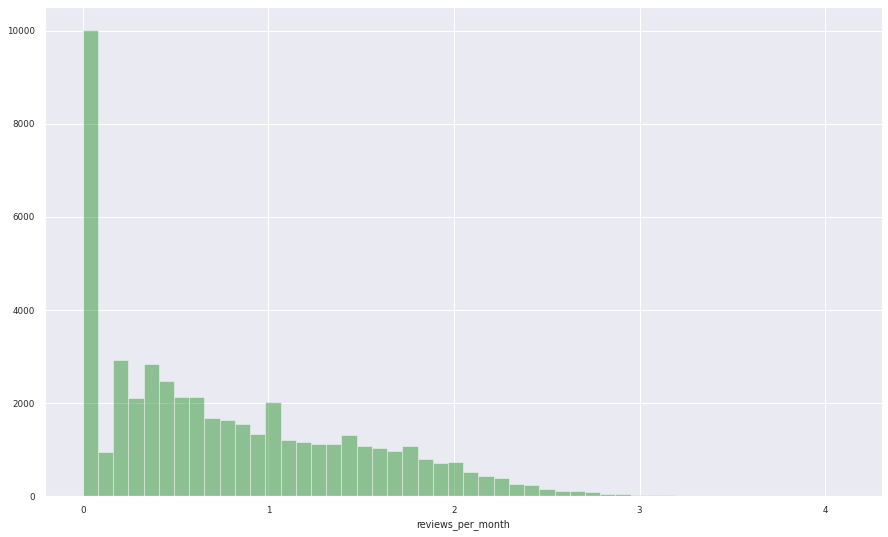

In [199]:
plt.figure(figsize=(15,9))
sns.distplot(np.sqrt(data_pred[data_pred['reviews_per_month'] < 17.5]['reviews_per_month']), rug=False, kde=False, color="green")

In [0]:
data_pred['reviews_per_month'] = data_pred[data_pred['reviews_per_month'] < 17.5]['reviews_per_month']

In [201]:
data_pred.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 5
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [0]:
data_pred['reviews_per_month'] = data_pred['reviews_per_month'].fillna(0)

## Availability 365

(0.0, 365.0)

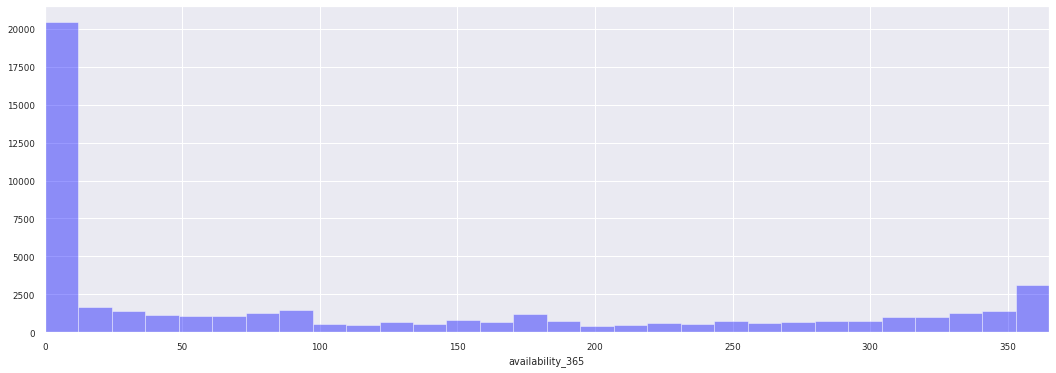

In [203]:
plt.figure(figsize=(18,6))
sns.distplot(data_pred['availability_365'], rug=False, kde=False, color="blue")
plt.xlabel('availability_365')
plt.xlim(0, 365)

This distribution is highly skewed towards the low and high end.

### Feature Engineering

In [0]:
data_pred['all_year_avail'] = data_pred['availability_365']>353
data_pred['low_avail'] = data_pred['availability_365']< 12
data_pred['no_reviews'] = data_pred['reviews_per_month']==0

## Now lets try and see the correlation 

In [0]:
data_pred.sort_values('price', ascending=True, inplace=True)

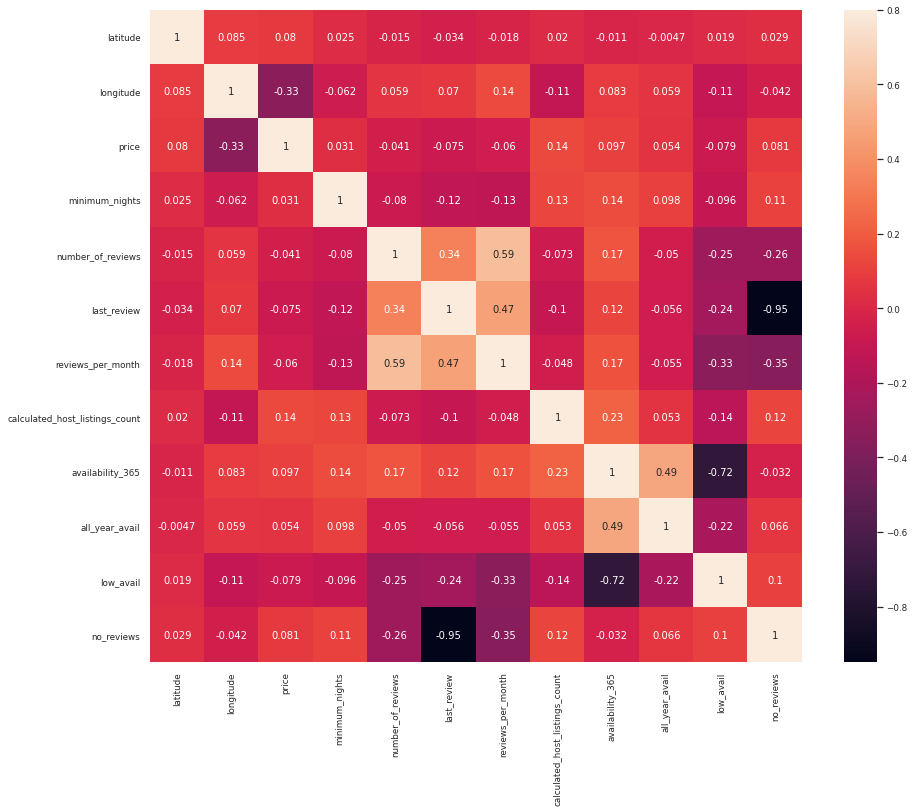

In [206]:
plt.figure(figsize=(15,12))
sns.heatmap(data_pred.corr(),annot=True, vmax=0.8, square=True)
sns.set(font_scale=0.8)

## Encoding categorical features

In [207]:
categorical_features = data_pred.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48784, 3)


In [208]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Chelsea,...,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
44442,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39926,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
45208,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
45274,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39805,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Saving the transformed dataframe

In [209]:
numerical_features =  data_pred.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48784, 11)


In [0]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)


In [211]:
X

array([[40.86209, -73.84666999999999, 1, ..., 0, 0, 1],
       [40.841190000000005, -73.87049, 10, ..., 0, 0, 1],
       [40.598420000000004, -73.95666999999999, 2, ..., 0, 0, 1],
       ...,
       [40.749320000000004, -74.00333, 1, ..., 0, 1, 0],
       [40.7354, -74.00208, 100, ..., 0, 1, 0],
       [40.77978, -73.97598, 1, ..., 1, 0, 0]], dtype=object)

In [212]:
X_df

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,all_year_avail,low_avail,no_reviews,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,...,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
44442,40.86209,-73.84667,1,0,0,0.00,1,5,False,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39926,40.84119,-73.87049,10,2,3016,0.32,4,114,False,False,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
45208,40.59842,-73.95667,2,1,2987,0.77,10,342,False,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
45274,40.59932,-73.95936,7,0,0,0.00,10,281,False,False,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39805,40.84047,-73.87127,14,1,2963,0.48,4,139,False,False,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,40.76810,-73.98377,1,0,0,0.00,1,0,False,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3782,40.74215,-73.98018,1,0,0,0.00,1,0,False,True,True,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
22373,40.74932,-74.00333,1,0,0,0.00,1,89,False,False,True,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
41770,40.73540,-74.00208,100,0,0,0.00,1,270,False,False,True,

In [0]:
Processed_data = pd.concat([X_df, y], axis = 1)
Processed_data.to_csv('Airbnb_Processed.dat')

In [0]:
Processed_data.to_csv('Airbnb_Processed.csv')

# Train test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
print("train x:",X_train.shape)
print("train y:",y_train.shape)
print("test x:",X_test.shape)
print("test y:",y_test.shape)

train x: (39027, 240)
train y: (39027,)
test x: (9757, 240)
test y: (9757,)


# Rescaling

Taking Robust Scaler so that the outliers are handelled if any..

In [0]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Trying out different models

Apllying cross validation..

In [0]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91)
    kf=kf.get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf,)

Scoring models (no parameter tuning)

In [0]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 5163080771062.23242 +/- 7187978937745.965820
Ridge: 0.20056 +/- 0.005966
Lasso: 0.45210 +/- 0.006634
ElasticNet: 0.45141 +/- 0.006620
RandomForestRegressor: 0.17687 +/- 0.005485
[16:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor: 0.18415 +/- 0.006391
HuberRegressor: 0.21887 +/- 0.003504


# Ridge Regression
Hyperparameter optimization

In [0]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [237]:
cv_ridge1

[0.201302336277501,
 0.201277951003182,
 0.20120110780311445,
 0.20106784414888007,
 0.2010141981563928,
 0.2010616146693418,
 0.20122990436632845,
 0.2013988529092356,
 0.20188096410579542,
 0.20249190936556696,
 0.20321380449850257]

In [0]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

In [239]:
cv_ridge2

[0.20101448344482398,
 0.20101065241285782,
 0.2010141981563928,
 0.2010224153294014,
 0.20103367790117438,
 0.20104696508409017,
 0.2010616146693418,
 0.2010771860406216]

In [240]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 
cv_ridge1

0.05     0.201302
0.10     0.201278
0.30     0.201201
1.00     0.201068
3.00     0.201014
5.00     0.201062
10.00    0.201230
15.00    0.201399
30.00    0.201881
50.00    0.202492
75.00    0.203214
dtype: float64

In [241]:
cv_ridge1.shape

(11,)

Text(0, 0.5, 'mse')

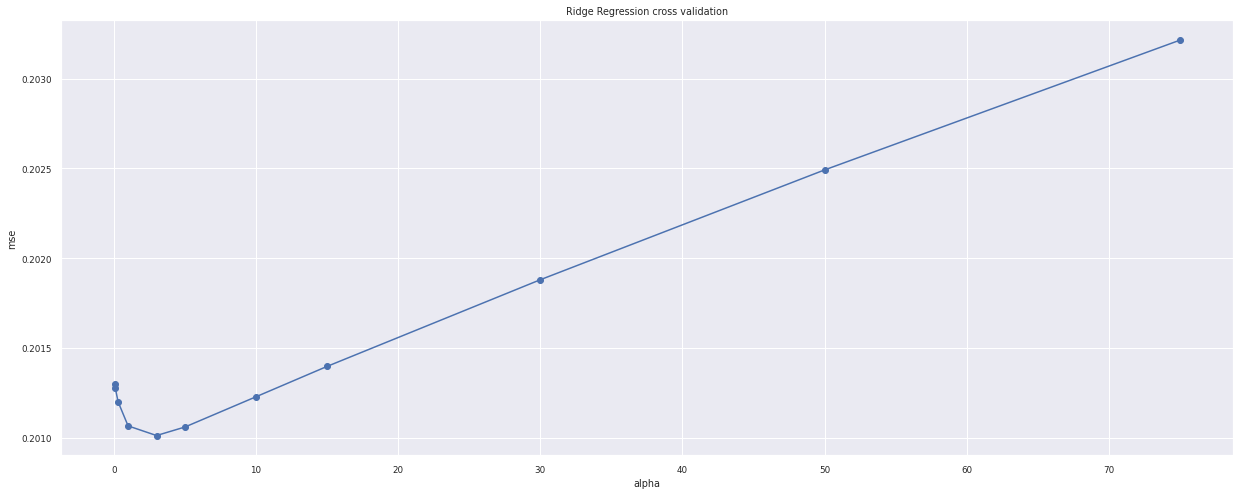

In [242]:
plt.figure(figsize=(21,8))
plt.plot(cv_ridge1.index,cv_ridge1,marker="o")
plt.title("Ridge Regression cross validation")
plt.xlabel("alpha")
plt.ylabel("mse")

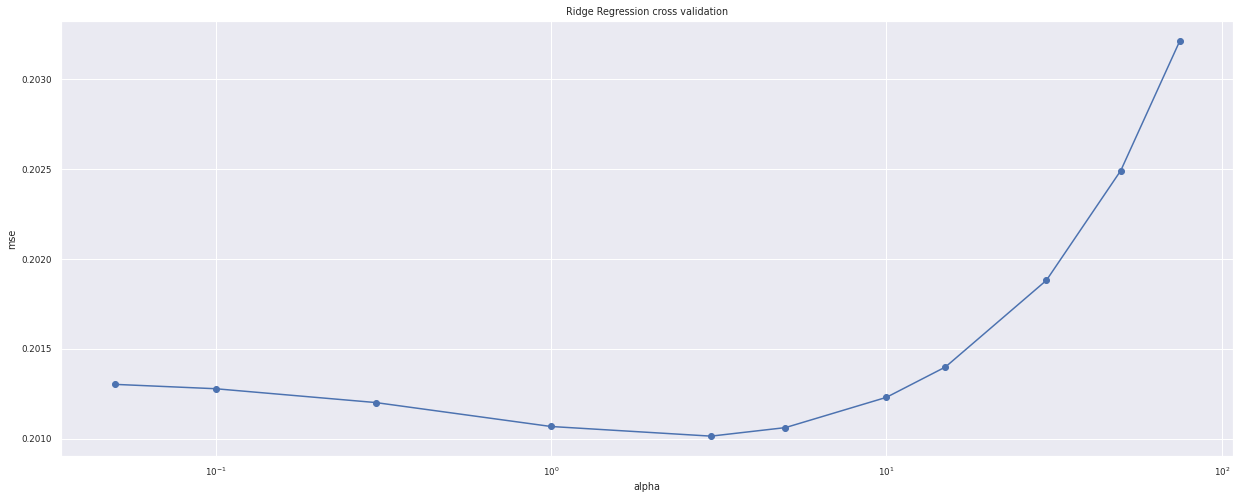

In [243]:
plt.figure(figsize=(21,8))
plt.plot(cv_ridge1.index,cv_ridge1,marker="o")
plt.title("Ridge Regression cross validation")
plt.xlabel("alpha")
plt.ylabel("mse")
plt.xscale("log")

Text(0, 0.5, 'mse')

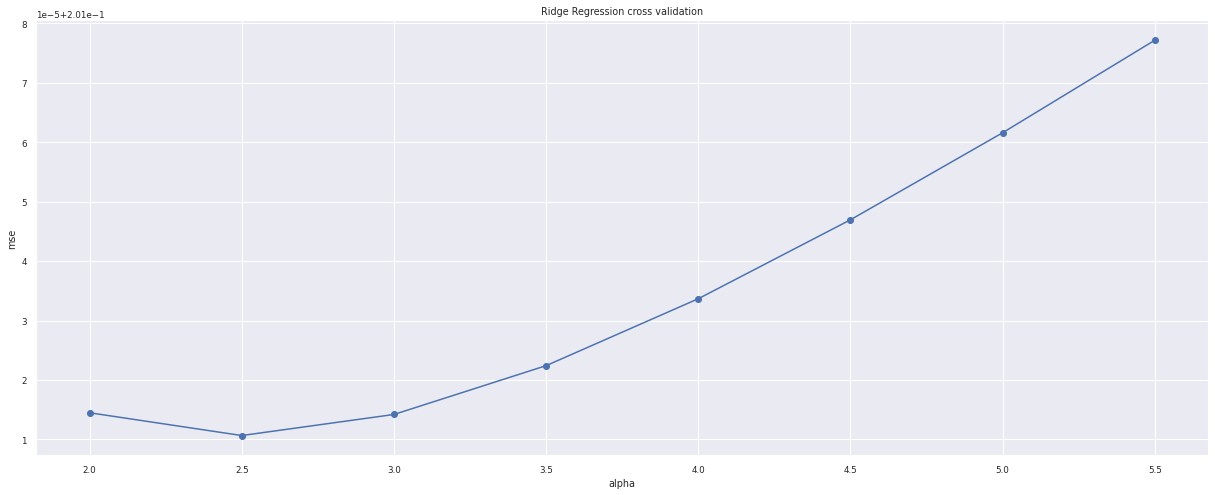

In [244]:
plt.figure(figsize=(21,8))
plt.plot(alphas2,cv_ridge2,marker="o")
plt.title("Ridge Regression cross validation")
plt.xlabel("alpha")
plt.ylabel("mse")

In [0]:
best_alpha=2.5
best_cv=-rmse_cv(Ridge(alpha=best_alpha))

In [246]:
best_cv

array([0.20074727, 0.20196125, 0.2021116 , 0.19747629, 0.20275685])

In [0]:
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)

In [248]:
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': best_cv.mean(), 
            'CV std': best_cv.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.201011,0.001883,0.198338,0.0,0.56891,0.565376


## LASSO Regression

In [0]:
alphas = [0.00001,0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

In [0]:
cv_lasso = pd.Series(cv_lasso, index = alphas)

Text(0.5, 1.0, 'Lasso Regression Cross-Validation')

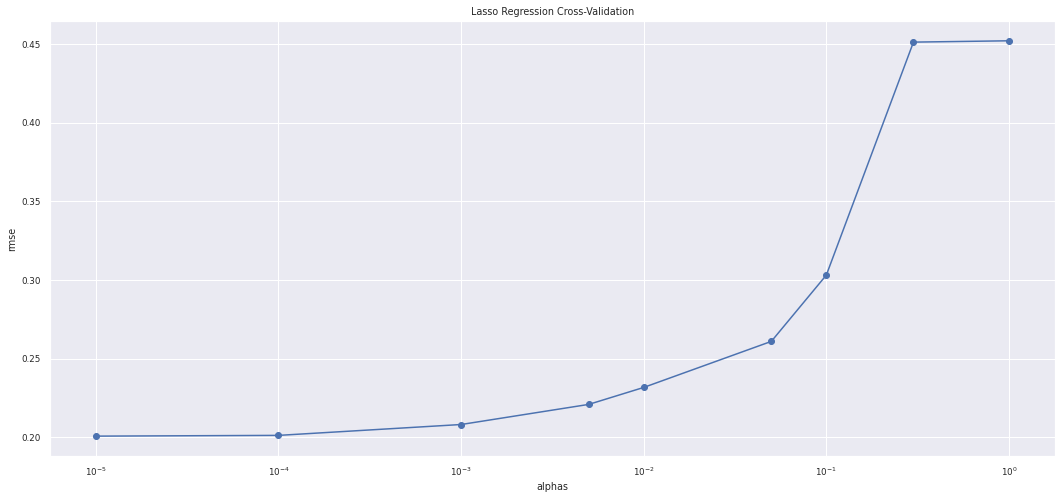

In [0]:
plt.figure(figsize=(18,8))
plt.plot(alphas,cv_lasso,marker="o")
plt.xlabel("alphas")
plt.ylabel("rmse")
plt.xscale("log")
plt.title("Lasso Regression Cross-Validation")

In [0]:
best_alpha=0.0001
best_lasso_cv=-rmse_cv(Lasso(alpha=best_alpha))

In [0]:
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)

In [0]:
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': best_lasso_cv.mean(), 
            'CV std': best_lasso_cv.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,LASSO Regression,0.201696,0.001886,0.200134,0.198502,0.565008,0.563906


### We took the alpha to be 0.0001 instead of 0.00001 although the second alpha gave a lower rmse value, because in lasso regression... *alpha=0.00001* eleminated only 26 attributes whereas *alpha=0.0001* eliminated 131 attributes which is a lot more compared to 26 and the cost of rmse difference is very tiny..

### Variables selected

In [0]:
features = list(numerical_features.columns)+list(categorical_features_one_hot.columns)

In [0]:
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 109 variables and eliminated the other 131 variables


## Hubber Regression

In [111]:
alphas = [0.001, 0.005, 0.05, 0.1, 0.3, 1,5] 
cv_huber = [-rmse_cv(HuberRegressor(alpha = alpha, max_iter=100)).mean() for alpha in alphas]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

In [112]:
cv_huber 

[0.2197445427282519,
 0.21901127291954384,
 0.21792334815163966,
 0.21960982063485074,
 0.2140726745932046,
 0.21725302946941832,
 0.21778914908225883]

In [0]:
cv_hubber=pd.Series(cv_huber,index=alphas)

Text(0.5, 1.0, 'Hubber Regression cross validation')

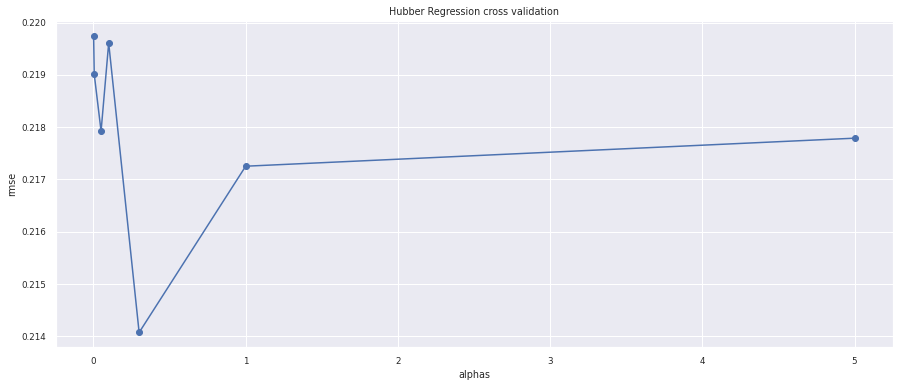

In [114]:
plt.figure(figsize=(15,6))
plt.plot(alphas,cv_huber,marker="o")
plt.xlabel("alphas")
plt.ylabel("rmse")
plt.title("Hubber Regression cross validation")

In [0]:
best_alpha = 0.3

In [116]:
huber_CV_best = -rmse_cv(HuberRegressor(alpha=best_alpha))
huber = HuberRegressor(alpha=best_alpha)
huber.fit(X_train, y_train) 
y_train_huber = huber.predict(X_train)
y_test_huber = huber.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

In [117]:
huber_results = pd.DataFrame({'algorithm':['Huber Regression'],
            'CV error': huber_CV_best.mean(), 
            'CV std': huber_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_huber)],
            'test error': [mean_squared_error(y_test, y_test_huber)],
            'training_r2_score': [r2_score(y_train, y_train_huber)],
            'test_r2_score': [r2_score(y_test, y_test_huber)]})
huber_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Huber Regression,0.214073,0.004457,0.21725,0.216138,0.527807,0.525162


## Ridge with variables selected by lasso

In [0]:
lasso_coef = coef[coef!=0]
Xlv = X_df[list(lasso_coef.index)]

In [0]:
Xlv_train, Xlv_test, y_train, y_test = train_test_split(Xlv, y, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix for lasso variable selection: {}'.format(Xlv_train.shape))
print('Dimensions of the test feature matrix for lasso variable selection: {}'.format(Xlv_test.shape))

Dimensions of the training feature matrix for lasso variable selection: (39027, 109)
Dimensions of the test feature matrix for lasso variable selection: (9757, 109)


In [0]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    cv_res = rmse_lv_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.20120 +/- 0.001922
Ridge: 0.20116 +/- 0.001838
Lasso: 0.44830 +/- 0.003365
ElasticNet: 0.44745 +/- 0.003263
RandomForestRegressor: 0.17850 +/- 0.002476
[14:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor: 0.18427 +/- 0.002354
HuberRegressor: 0.24701 +/- 0.005617


### Ridge hyperparameter optimisation

In [0]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [0]:
alphas2 = [0.5*i for i in range(1,12)]
cv_ridge2 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

In [0]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

Text(0.5, 1.0, 'Ridge regression cross validation')

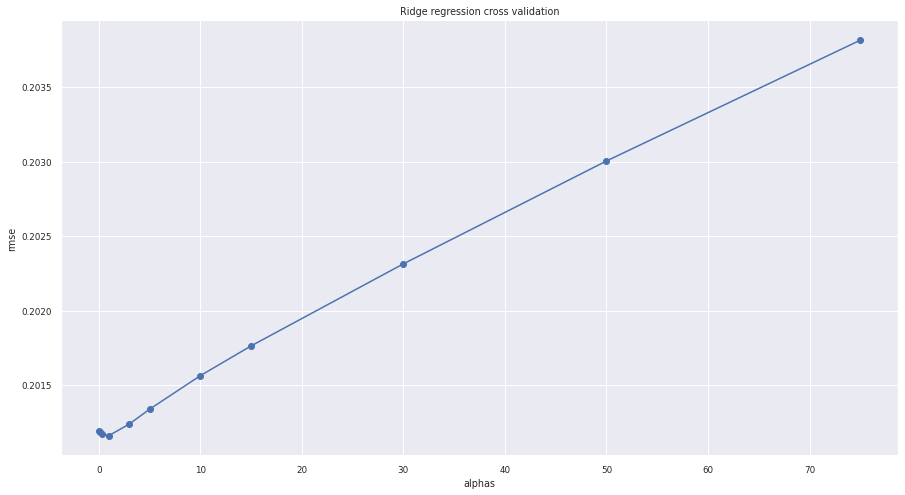

In [0]:
plt.figure(figsize=(15,8))
plt.plot(alphas1,cv_ridge1,marker="o")
plt.xlabel("alphas")
plt.ylabel("rmse")
plt.title("Ridge regression cross validation")

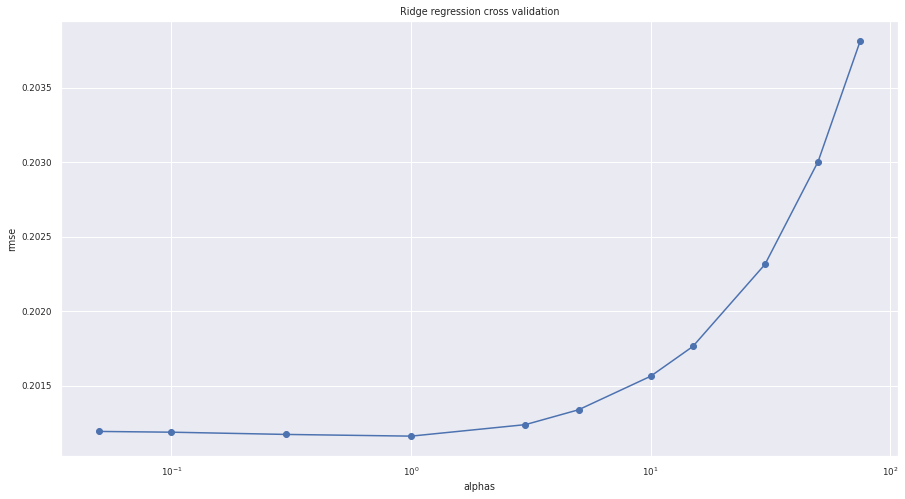

In [0]:
plt.figure(figsize=(15,8))
plt.plot(alphas1,cv_ridge1,marker="o")
plt.xlabel("alphas")
plt.ylabel("rmse")
plt.title("Ridge regression cross validation")
plt.xscale("log")

Text(0.5, 1.0, 'Ridge regression cross validation')

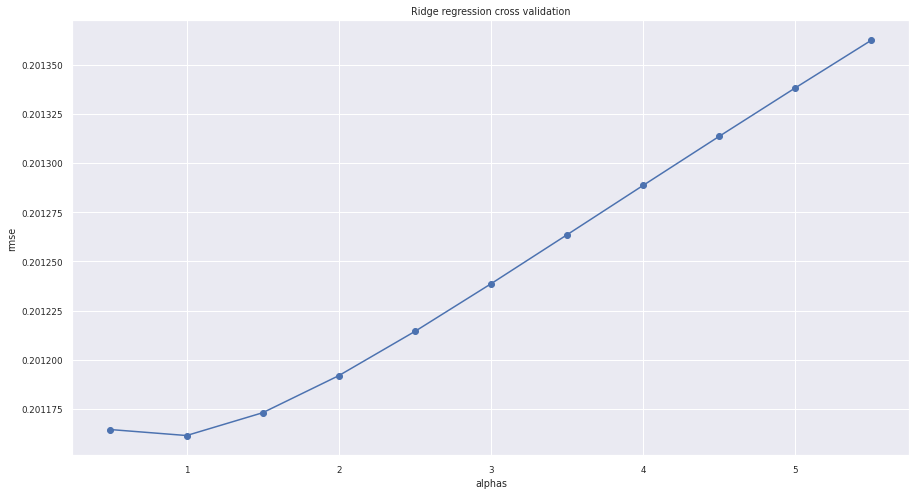

In [0]:
plt.figure(figsize=(15,8))
plt.plot(alphas2,cv_ridge2,marker="o")
plt.xlabel("alphas")
plt.ylabel("rmse")
plt.title("Ridge regression cross validation")

In [0]:
best_alpha = 1

In [0]:
RR_lassoVars_CV_best = -rmse_lv_cv(Ridge(alpha = best_alpha))
RR_lassoVars = Ridge(alpha = best_alpha) 
RR_lassoVars.fit(Xlv_train, y_train) 
y_train_RR_lassoVars = RR_lassoVars.predict(Xlv_train)
y_test_RR_lassoVars = RR_lassoVars.predict(Xlv_test)

In [0]:
ridge_lassoVars_results = pd.DataFrame({'algorithm':['Ridge Regression with LASSO variable selection'],
            'CV error': RR_lassoVars_CV_best.mean(), 
            'CV std': RR_lassoVars_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR_lassoVars)],
            'test error': [mean_squared_error(y_test, y_test_RR_lassoVars)],
            'training_r2_score': [r2_score(y_train, y_train_RR_lassoVars)],
            'test_r2_score': [r2_score(y_test, y_test_RR_lassoVars)]})

In [0]:
ridge_lassoVars_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression with LASSO variable selection,0.201161,0.001838,0.199565,0.198448,0.566244,0.564027


## Random Forest Regressor

In [0]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))

In [0]:
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)

In [0]:
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})
rfr_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Random Forest Regressor [baseline],0.17859,0.002366,0.024585,0.175528


We can see that it is overfitting massively..

Thus lets try for hyperparameter 

In [0]:
print('Parameters currently in use: \n')
print(rfr_baseline.get_params())

Parameters currently in use: 

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [0]:
random_grid = {'n_estimators': [int(x) for x in range(100, 1500,20)],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [int(x) for x in range(10, 100, 10)],
        'min_samples_split': [2,5,10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

In [0]:
rf_random = RandomizedSearchCV(estimator=rfr_baseline, param_distributions = random_grid, n_iter=3, cv = 3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
best_random = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.176033,0.002325,0.067844,0.171992,0.852541,0.622149


## XGBoost Regressor

Model using Default parameters

In [0]:
xgb_baseline = XGBRegressor(random_state=42)
xgb_cv_baseline=-rmse_cv(xgb_baseline)

[16:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:16:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': xgb_cv_baseline.mean(), 
            'CV std': xgb_cv_baseline.std(),
            'training error': [mean_squared_error(y_train,y_train_xgb_base)],
            'test error':[mean_squared_error(y_test,y_test_xgb_base)],
            'training_r2_score':[r2_score(y_train,y_train_xgb_base)],
            'test_r2_score':[r2_score(y_test,y_test_xgb_base)]})

[16:19:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
xgb_baseline_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor[baseline],0.184331,0.002255,0.179399,0.184672,0.610074,0.594291


In [0]:
xgb_results1 ={'Learning Rate': [],
            'CV error': [], 
            'CV std': [],
            'training error': [],
            'test error':[],
            'training_r2_score':[],
            'test_r2_score':[]}

In [0]:
for lr in [0.01,0.05,0.1,0.5]:
  xgb_model = XGBRegressor(n_estimators=50, learning_rate=lr, early_stopping=5)
  cv_res=-rmse_cv(xgb_model)
  xgb_model.fit(X_train, y_train)
  y_train_xgb = xgb_model.predict(X_train)
  y_test_xgb = xgb_model.predict(X_test)
  xgb_results1['Learning Rate'].append(lr)
  xgb_results1['CV error'].append(cv_res.mean())
  xgb_results1['CV std'].append(cv_res.std())
  xgb_results1['training error'].append(mean_squared_error(y_train,y_train_xgb))
  xgb_results1['test error'].append(mean_squared_error(y_test,y_test_xgb))
  xgb_results1['training_r2_score'].append(r2_score(y_train,y_train_xgb))
  xgb_results1['test_r2_score'].append(r2_score(y_test,y_test_xgb))


[16:51:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
xgb_results1=pd.DataFrame(xgb_results1)
xgb_results1

,Learning Rate,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,0.01,6.881372,0.049202,6.880655,6.892024,-13.955151,-14.141215
1,0.05,0.317117,0.004823,0.315475,0.323403,0.314314,0.289510
2,0.10,0.192947,0.002184,0.189975,0.193252,0.587087,0.575441
3,0.50,0.181887,0.002837,0.173607,0.182651,0.622664,0.598730


In [0]:
print(xgb_model.get_params)

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>


Text(0.5, 1.0, 'xgb alpha vs cv error')

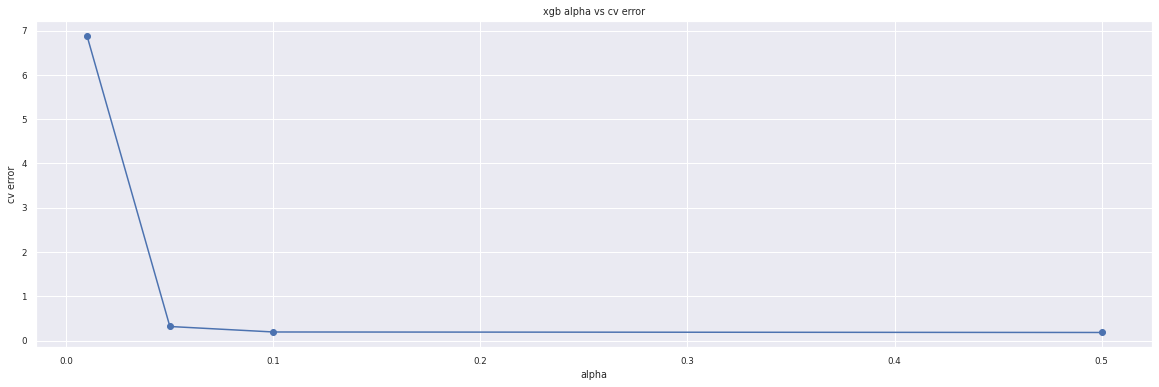

In [0]:
plt.figure(figsize=(20,6))
plt.plot(xgb_results1['Learning Rate'],xgb_results1['CV error'],marker='o')
plt.xlabel("alpha")
plt.ylabel("cv error")
plt.title("xgb alpha vs cv error")

Text(0.5, 1.0, 'xgb alpha vs training error')

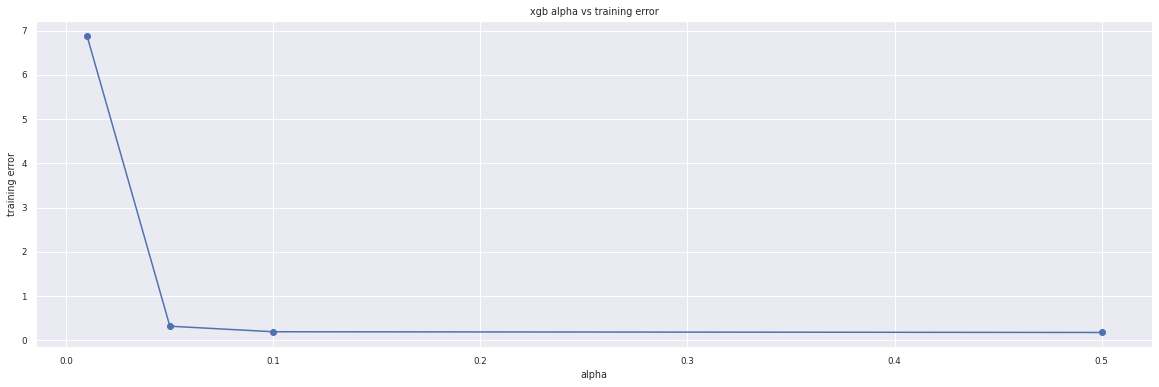

In [0]:
plt.figure(figsize=(20,6))
plt.plot(xgb_results1['Learning Rate'],xgb_results1['training error'],marker='o')
plt.xlabel("alpha")
plt.ylabel("training error")
plt.title("xgb alpha vs training error")

leaves optimization

In [0]:
xgb_results2 ={'Learning Rate': [],
            'CV error': [], 
            'CV std': [],
            'training error': [],
            'test error':[],
            'training_r2_score':[],
            'test_r2_score':[]}

In [0]:
xgbreg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}
params2

{'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]}

In [0]:
xgb_random = RandomizedSearchCV(estimator=xgbreg, param_distributions = params2, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.8min finished


[18:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, early_stopping=5,
                                          gamma=0, importance_type='gain',
                                          learning_rate=0.05, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=50,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                

In [0]:
xgb_best=xgb_random.best_estimator_
xgb_best

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=9, min_child_weight=5, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=9, min_child_weight=5, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
cv_res = -rmse_cv(xgb_model)
xgb_model.fit(X_train, y_train)
y_train_xgb = xgb_model.predict(X_train)
y_test_xgb = xgb_model.predict(X_test)
xgb_results = pd.DataFrame({'algorithm':['XGBRegressor leaves optimized'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train,y_train_xgb)],
            'test error':[mean_squared_error(y_test,y_test_xgb)],
            'training_r2_score':[r2_score(y_train,y_train_xgb)],
            'test_r2_score':[r2_score(y_test,y_test_xgb)]})

[18:16:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:16:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:16:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
xgb_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor leaves optimized,0.288808,0.003651,0.263431,0.300789,0.427432,0.339192


Best model

In [0]:
xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
xbgreg_best = XGBRegressor(n_estimators=500, learning_rate=0.05, early_stopping=5, max_depth=5, min_child_weight=5 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

[18:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:50:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:56:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.173889,0.001995,0.153384,0.175212,0.666618,0.615074


However can be better if more n_estimators are used..